# mSSA on EXP coefficients

Begin with the usual imports...

In [1]:
import os
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt

### Get some example data

We provide a set of reference simulations in the `Tutorials/Data` directory.  We'll read the `DiskHalo` basis configuration and coefficients for this example.   This is a very short simulation so will not be able to study the evolution of the m=2 response in detail.  Rather, we are illustrating the basic steps of an mSSA analysis here.

In [2]:
# Switch to the Data directory to get our example data
os.chdir('../Data')

# Get the basis config
#
yaml_config = ""
with open('config.yml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    yaml_config = yaml.dump(config['Components'][1]['force'])


# Construct the basis instance
#
basis = pyEXP.basis.Basis.factory(yaml_config)

# Make the coefficients by the factory method
#
coefs = pyEXP.coefs.Coefs.factory('outcoef.star disk.run0')

# Return to the working directory
os.chdir('../mSSA')

print('The coefficient time list is', coefs.Times())

Cylindrical: parameter 'density' is deprecated. The density field will be computed regardless.
The coefficient time list is [0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.06, 0.062, 0.064, 0.066, 0.068, 0.07, 0.072, 0.074, 0.076, 0.078, 0.08, 0.082, 0.084, 0.086, 0.088, 0.09, 0.092, 0.094, 0.096, 0.098, 0.1, 0.102, 0.104, 0.106, 0.108, 0.11, 0.112, 0.114, 0.116, 0.118, 0.12, 0.122, 0.124, 0.126, 0.128, 0.13, 0.132, 0.134, 0.136, 0.138, 0.14, 0.142, 0.144, 0.146, 0.148, 0.15, 0.152, 0.154, 0.156, 0.158, 0.16, 0.162, 0.164, 0.166, 0.168, 0.17, 0.172, 0.174, 0.176, 0.178, 0.18, 0.182, 0.184, 0.186, 0.188, 0.19, 0.192, 0.194, 0.196, 0.198, 0.2]
---- EmpCylSL::ReadH5Cache: read <eof.cache.run0>
---- EmpCylSL::read_cache: table forwarded to all processes
---- Cylindrical::orthoTest: worst=0.00529627


### Visualize the field data for intuition

Now, let's construct some slices for rendering

Creating surfaces with times: [0.198, 0.2]
Created fields instance
Created surfaces
We now have the following [time field] pairs
----------------------------------------
  0.1980  azi force
  0.1980  dens
  0.1980  dens m=0
  0.1980  dens m>0
  0.1980  potl
  0.1980  potl m=0
  0.1980  potl m>0
  0.1980  rad force
  0.1980  ver force
----------------------------------------
  0.2000  azi force
  0.2000  dens
  0.2000  dens m=0
  0.2000  dens m>0
  0.2000  potl
  0.2000  potl m=0
  0.2000  potl m>0
  0.2000  rad force
  0.2000  ver force


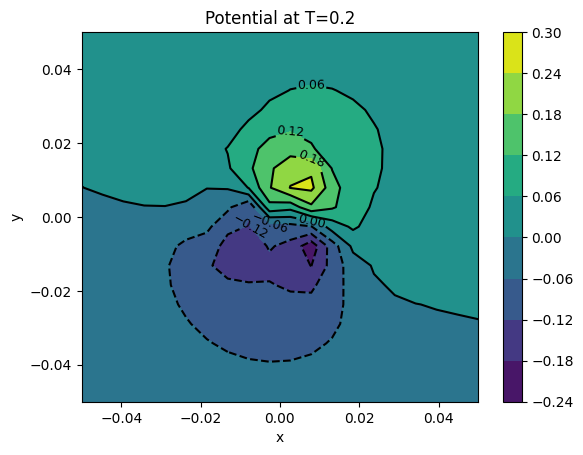

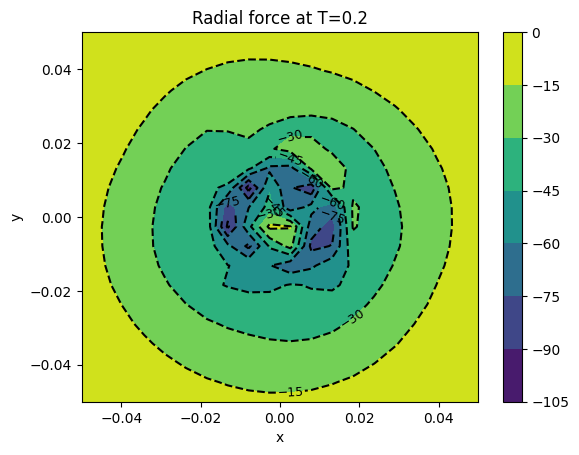

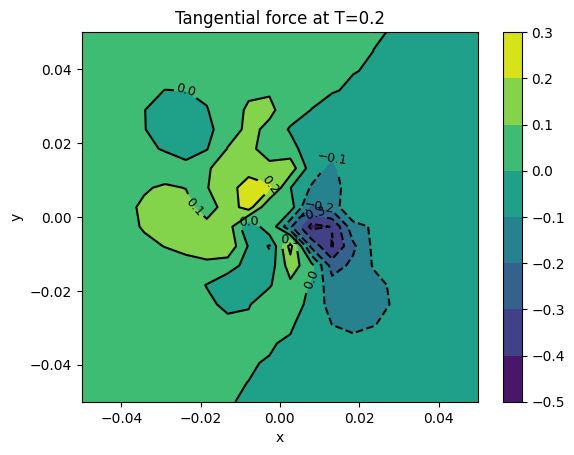

In [3]:
times = coefs.Times()[-2:]
pmin  = [-0.05, -0.05, 0.0]
pmax  = [ 0.05,  0.05, 0.0]
grid  = [    20,   20,   0]

print('Creating surfaces with times:', times)

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

print('Created fields instance')

surfaces = fields.slices(basis, coefs)

print('Created surfaces')

print("We now have the following [time field] pairs")
final = 0.0
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))
        final = v

# Print the potential image at the final time
# 
nx = surfaces[final]['potl m>0'].shape[0]
ny = surfaces[final]['potl m>0'].shape[1]

x = np.linspace(pmin[0], pmax[0], nx)
y = np.linspace(pmin[1], pmax[1], ny)
xv, yv = np.meshgrid(x, y)

cont1 = plt.contour(xv, yv, surfaces[final]['potl m>0'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['potl m>0'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['rad force'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['rad force'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['azi force'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['azi force'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Tangential force at T={}'.format(final))
plt.show()

### An mSSA example

We begin by configuring expMSSA with the desired coefficient channels.  As an example, we'll use some of the 
lowest-order m=2 coefficients for the disk.

We begin by making some YAML parameter flags for `expMSSA`.  The defaults should work fine
for most people.  `chatty` turns on `std::cout` diagnostics and `output` is the prefix for written files.

In [4]:
flags ="""
---
# chatty: on
output: mytest2
...
"""

# Make a subkey sequence
#
keylst = coefs.makeKeys([2])
print("All m=2 keys=", keylst)

# Make some custom [m, n] pairs
keylst = [[2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7]]
print("Custom keys=", keylst)

config = {"star disk": (coefs, keylst, [])}

window = int(len(coefs.Times())/2)
npc = 20

print("Window={} PC number={}".format(window, npc))

startTime = time.time()
ssa = pyEXP.mssa.expMSSA(config, window, npc, flags)

All m=2 keys= [[2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11]]
Custom keys= [[2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7]]
Window=50 PC number=20
---- Eigen is using 4 threads


### Plot the mSSA singular values (eigenvalues)

The magnitude of these reveal the relative variance contained in each component.  The large the variance, the larger the contribution of the PC to correlated dynamics.

Computed eigenvalues in   2.72 seconds
shape U = 800 x 52
shape Y = 52 x 800


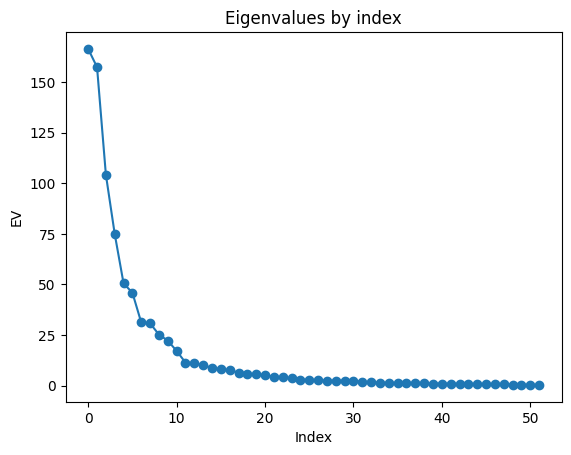

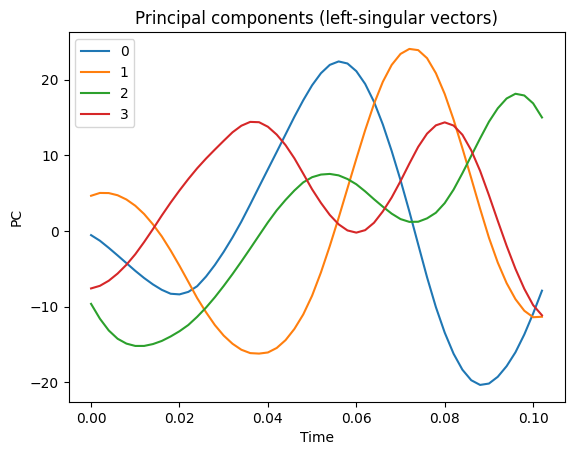

In [5]:
ev = ssa.eigenvalues()
print('Computed eigenvalues in {:6.2f} seconds'.format(time.time() - startTime))

plt.plot(ev, 'o-')
plt.xlabel("Index")
plt.ylabel("EV")
plt.title("Eigenvalues by index")
plt.show()

times = coefs.Times()
pc = ssa.getPC()

rows, cols = pc.shape

for i in range(min(cols,4)):
    plt.plot(times[0:rows], pc[:,i], '-', label="{:d}".format(i))

plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("Principal components (left-singular vectors)")
plt.show()

### Use k-means to estimate grouping

Based on the eigenvalue plot above, we'll perform an analysis with the first 10 PCs and allow up to 6 clusters.  For a small time series like this one, the idenification of clusters will be uncertain.  

Note that `stride=2`specifies choosing initial k-means centers from the PC list with a stride of 2.  This is a good choice for quasi-periodic signals typical of galactic dynamics.  If one chooses `stride=0`, the k-means algorithm is seeded randomly from the list of input PCs.  Try rerunning the following cell with `stride=0` to get a sense of the predicted cluster variation.

In [6]:
ssa.reconstruct([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

print('Calling k-means')
id, dist, err = ssa.kmeans(clusters=6, stride=2)
print('Return error:', err)

# Print the results
print('\n')
print('{:<4s} | {:<4s} | {:<13s}'.format('PC', 'id', 'distance'))
print('{:<4s} | {:<4s} | {:<13s}'.format('----', '----', '--------'))
for k in range(len(id)):
    print('{:<4d} | {:<4d} | {:<13.6e}'.format(k, id[k], dist[k]))

Calling k-means
Return error: 0.0


PC   | id   | distance     
---- | ---- | --------     
0    | 0    | 1.086620e+01 
1    | 0    | 9.378173e+00 
2    | 1    | 5.533200e+00 
3    | 1    | 5.533200e+00 
4    | 2    | 1.941132e+00 
5    | 2    | 1.941132e+00 
6    | 3    | 9.869945e-01 
7    | 3    | 9.869945e-01 
8    | 4    | 2.641111e+00 
9    | 4    | 2.641111e+00 
10   | 0    | 1.862086e+00 
11   | 0    | 1.862086e+00 
12   | 0    | 1.862086e+00 
13   | 0    | 1.862086e+00 
14   | 0    | 1.862086e+00 
15   | 0    | 1.862086e+00 
16   | 0    | 1.862086e+00 
17   | 0    | 1.862086e+00 
18   | 0    | 1.862086e+00 
19   | 0    | 1.862086e+00 


Let's compare this with the results from the w-correlation matrix for all channels:

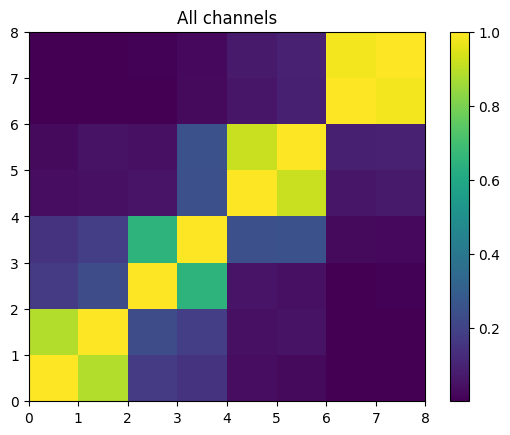

In [10]:
mat = ssa.wCorrAll(8)
x = plt.pcolormesh(mat)
plt.title("All channels")
plt.colorbar(x)
plt.show()

The w-correlation matrix also indicates 5 groups of pairs, corroborating the k-means findings.  An eigenvalue plot for this analysis is plotted below.  We clearly see that eigenvalues 10-20 carry little variance and most likely consistent with uncorrelated noise.

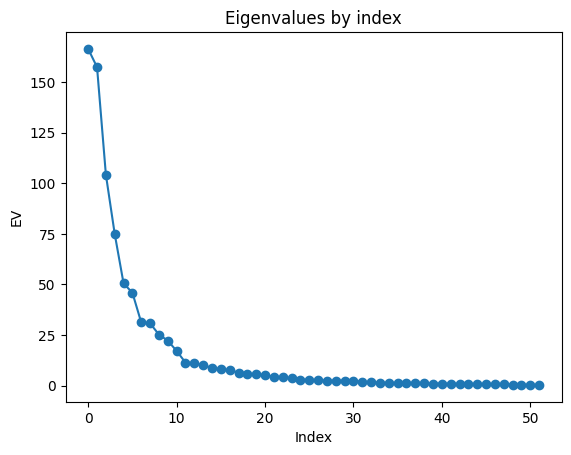

In [20]:
ev = ssa.eigenvalues()

plt.plot(ev, 'o-')
plt.xlabel("Index")
plt.ylabel("EV")
plt.title("Eigenvalues by index")
plt.show()

### Try a reconstruction for the first two PCs

We can see from the singular value plot above that the first pair of PCs dominate the variance

Calling reconstruction
Reconstruction took   0.01 seconds
newdata is a <class 'dict'>
Created surfaces from reconstruction
We now have the following [time field] pairs
----------------------------------------
  0.1980  azi force
  0.1980  dens
  0.1980  dens m=0
  0.1980  dens m>0
  0.1980  potl
  0.1980  potl m=0
  0.1980  potl m>0
  0.1980  rad force
  0.1980  ver force
----------------------------------------
  0.2000  azi force
  0.2000  dens
  0.2000  dens m=0
  0.2000  dens m>0
  0.2000  potl
  0.2000  potl m=0
  0.2000  potl m>0
  0.2000  rad force
  0.2000  ver force


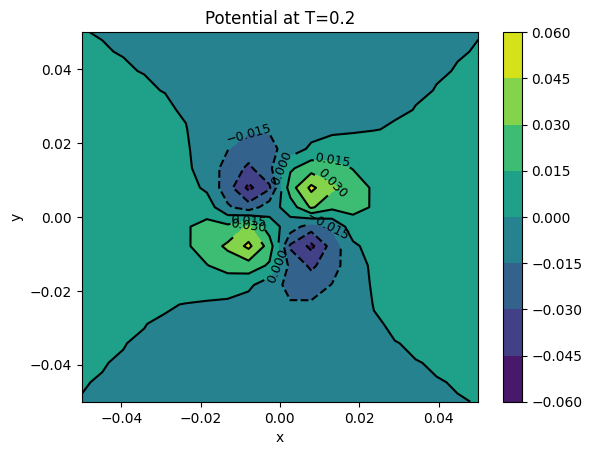

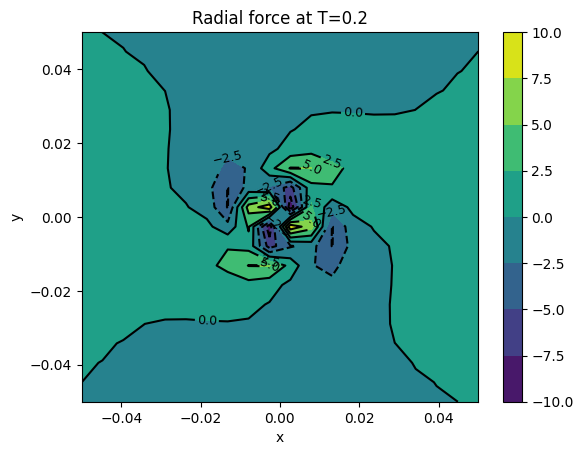

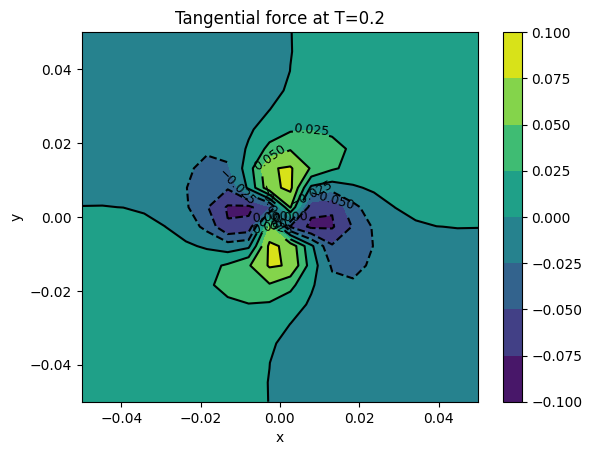

In [14]:
startTime = time.time()
print('Calling reconstruction')
ssa.reconstruct([0, 1])
print('Reconstruction took {:6.2f} seconds'.format(time.time() - startTime))

# Zero all but reconstructed
coefs.zerodata()
newdata = ssa.getReconstructed() 
print('newdata is a', type(newdata))

surfaces = fields.slices(basis, newdata['star disk'])

print('Created surfaces from reconstruction')

print("We now have the following [time field] pairs")
final = 0.0
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))
        final = v

# Print the potential image at the final time (I think there is a
# fencepost issue in this grid, no matter).
nx = surfaces[final]['potl m>0'].shape[0]
ny = surfaces[final]['potl m>0'].shape[1]

x = np.linspace(pmin[0], pmax[0], nx)
y = np.linspace(pmin[1], pmax[1], ny)
xv, yv = np.meshgrid(x, y)

cont1 = plt.contour(xv, yv, surfaces[final]['potl m>0'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['potl m>0'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['rad force'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['rad force'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['azi force'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['azi force'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Tangential force at T={}'.format(final))
plt.show()

***

## Where do you want to go next?

- [Return to Table of Contents](../README.ipynb)
- [Back to previous notebook](cosine%20multichannel.ipynb)
- [Go to next notebook](../Orbits/orbits%20in%20an%20EXP%20field.ipynb)
